In [1]:
# language_model="claude-3-5-sonnet-20240620"
language_model = "gpt-4o-mini"

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model=language_model, temperature=0, api_key="",
    max_tokens=None,
    timeout=None,
    max_retries=2)

# llm = ChatOpenAI(
#     base_url="https://api.together.xyz/v1",
#     api_key="",
#     model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",max_retries=2, temperature=0)


# from langchain_anthropic import ChatAnthropic

# llm = ChatAnthropic(
#     model=language_model,
#     temperature=0,
#     max_tokens=1024,
#     timeout=None,
#     max_retries=2,
#     api_key="
# )

In [2]:
from langchain.chains import LLMChain
from langchain_core.prompts import PromptTemplate
from langchain_openai import OpenAI
from openinference.instrumentation.langchain import LangChainInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.trace.export import ConsoleSpanExporter, SimpleSpanProcessor
from opentelemetry.sdk.trace.export import (
    BatchSpanProcessor,
    SpanExporter,
    SpanExportResult,
)
from opentelemetry.sdk.trace import ReadableSpan

from pathlib import Path
import os

class FileSpanExporter(SpanExporter):
    def __init__(self, file_name: str):
        self.file_name = file_name

    def export(self, spans: list[ReadableSpan]) -> SpanExportResult:
        with open(self.file_name, "a") as f:
            for span in spans:
                f.write(span.to_json().replace("\n", "") + "\n")
        return SpanExportResult.SUCCESS

    def shutdown(self):
        pass


# endpoint = "http://127.0.0.1:6006/v1/traces"
tracer_provider = trace_sdk.TracerProvider()
trace_api.set_tracer_provider(tracer_provider)
# tracer_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint)))
tracer_provider.add_span_processor(
    BatchSpanProcessor(
        FileSpanExporter(
            Path(os.path.abspath("")) / f"trace_langchain_{language_model}.json"
        )
    )
)

LangChainInstrumentor().instrument()

In [3]:
import json
import os
from pathlib import Path
from typing import Annotated, Dict, Sequence, TypedDict, Union
from langchain.agents import tool
from masterthesis.agent.GitAgent import GitAgent
from masterthesis.agent.LSPAgent import LSPAgent
from masterthesis.agent.MavenReproducerAgent import MavenReproducerAgent
from masterthesis.agent.TreeAgent import get_directory_tree
from masterthesis.agent.aider.AdvancedDiffAgent import UnifiedDiffCoder
from masterthesis.dataset.dataset_types import DatasetEntry
from masterthesis.dataset.load_dataset import load_dataset
import operator
from langchain_core.messages import BaseMessage


filters = [# "0a11c04038eae517540051dbf51f7f26b7221f20", 
            # "0abf7148300f40a1da0538ab060552bca4a2f1d8", 
            "11be71ab8713fe987785e9e25e4f3e410e709ab9",
            "1ef97ea6c5b6e34151fe6167001b69e003449f95",
            "28be199c825d419957bc753a9519e8e9ecc6a08e",
            "979d6237a50840cd925cc1a33c415ffbbbc42846",
            "c7c9590a206d4fb77dd05b9df391d888e6181667",
            "dbdc7d2c4a28a8d65edcd0cdece91c0bc357b869"
            ]
candidates: Dict[str, DatasetEntry] = load_dataset(os.path.abspath("dataset"), filters)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    diffs: Annotated[Sequence[str], operator.add]

from opentelemetry import trace as trace_api

tracer = trace_api.get_tracer(__name__)


# for commit_hash, dataset_entry in candidates.items():

def get_tools_for_dataset_entry(dataset_entry: DatasetEntry) -> list:

    git_agent = GitAgent(
            Path(dataset_entry.repo_path),
            dataset_entry.commit_hash,
            dataset_entry.repo_slug,
    )
    git_agent.discard_changes()

    repo_path = Path(dataset_entry.repo_path)



    @tool
    def validate_diffs(diff:str) -> str:
        """Tests whether the Diff is applicable. Run this before compiling. Returns either a Diff Error or the applied file. Diff has to be wrapped in a Markdown codeblock and has to follow the file edit rules."""
        with tracer.start_as_current_span("validate_diffs") as span:
            print("[TOOL] Validating diff")
            coder = UnifiedDiffCoder(repo_path)
            success, result = coder.apply_edits(diff)
            span.set_attribute("validate_diffs_success", success)
            span.set_attribute("validate_diffs_result", str(result))
            if not success:
                span.set_attribute("validate_diffs_error", str(result))
                return "Diff Error: " + str(result)
            return result


    attempted_diffs: list[str] = []

    successful_diff:str = ""

    @tool
    def compile_maven(diff:str) -> str:
        """Compiles the project with the given diffs applied. Returns either a Compilation Error, Test Error or Compilation and Testing successful."""
        with tracer.start_as_current_span("compile_maven") as span:
            print("[TOOL] Compiling Maven")
            maven_agent = MavenReproducerAgent(repo_path)
            with maven_agent.start_container() as container:
                (compilation_has_succeeded, test_has_succeeded), error_text = (maven_agent.compile_maven([diff], run_tests=True))
                
                project_path = str(repo_path)
                def process_line(line: str):
                    if "Downloaded from" in line or "Downloading from" in line:
                        return ""

                    if project_path not in line:
                        return line.strip()

                    parts = line.split()
                    return " ".join(
                        part[len(project_path):] if part.startswith(project_path) else part
                        for part in parts
                    ).strip()
                
                processed_lines = [process_line(line) for line in error_text.split("\n")]
                
                error_text = "\n".join(
                    [line.strip() for line in processed_lines if len(line.strip()) > 0]
                )
                error_text = error_text.replace('\x00', "")
                
                span.set_attribute("compile_maven_compilation_has_succeeded", compilation_has_succeeded)
                span.set_attribute("compile_maven_test_has_succeeded", test_has_succeeded)
                span.set_attribute("compile_maven_error_text", error_text)

            print("[TOOL] Compilation has succeeded: ", compilation_has_succeeded, "Test has succeeded: ", test_has_succeeded)

            span.set_attribute("attempted_diff", diff)
            attempted_diffs.append(diff)
            if not compilation_has_succeeded:
                return "Compilation Error: " + error_text

            if not test_has_succeeded:
                return "Test Error: " + error_text
            
            if diff:
                successful_diffs = diff

            return f"Compilation and Testing successful: {error_text}"

    @tool
    def read_file(file_path:str) -> str:
        """Reads the file at the given path and returns it, or an error message if the file could not be read."""
        with tracer.start_as_current_span("read_file") as span:
            print("[TOOL] Reading file", file_path)
            try:
                span.set_attribute("read_file_file_path", file_path)
                with open(repo_path / file_path, "r") as file:
                    file_text = file.read()
                    span.set_attribute("read_file_success", True)
                    span.set_attribute("read_file_text", file_text)
                    return file_text
            except Exception as e:
                error_text = str(e).replace(str(repo_path), "")
                span.set_attribute("read_file_success", False)
                span.set_attribute("read_file_error", error_text)
                return "Error: " + error_text


    def diagnostic_stringifier(diagnostic):
            message = (diagnostic.get("message", "")).replace("/mnt/repo/", "")
            start_line = diagnostic["range"]["start"].get("line", 0)
            start_character = diagnostic["range"]["start"].get("character", 0)
            end_line = diagnostic["range"]["end"].get("line", start_line)
            end_character = diagnostic["range"]["end"].get("character", start_character)
            return f"[JAVA] {start_line}:{start_character} to {end_line}:{end_character} - {message}"
    @tool
    def get_language_server_suggestions(file_path:str, diff:str) -> list[str]:
        """Returns the Java language server suggestions for the given diff and file."""
        with tracer.start_as_current_span("read_file") as span:
            print("[TOOL] Getting language server suggestions")
            try:
                lsp_agent = LSPAgent(repo_path)
                lsp_result_initial, lsp_result_post_patching = (
                    lsp_agent.validate_changes(
                        Path(file_path), [diff]
                    )
                )

                post_patching_diagnostics = lsp_result_post_patching["diagnostics"]
                initial_diagnostics_set: set = set(
                    diagnostic_stringifier(d)
                    for d in lsp_result_initial["diagnostics"]
                )
                post_patching_diagnostics_set: set = set(
                    diagnostic_stringifier(d) for d in post_patching_diagnostics
                )
                added_diagnostics_set: set = (
                    post_patching_diagnostics_set - initial_diagnostics_set
                )
                stringified_diagnostics = [
                    diagnostic_stringifier(d)
                    for d in post_patching_diagnostics
                    if diagnostic_stringifier(d) in added_diagnostics_set
                ]
                span.set_attribute("get_language_server_suggestions_stringified_diagnostics", stringified_diagnostics)
                return stringified_diagnostics
            except Exception as e:
                error_text = str(e).replace(str(repo_path), "")
                span.set_attribute("get_language_server_suggestions_error", error_text)
                return "Error: " + error_text
            




    @tool
    def get_directory_tree_for_path(relative_directory_path:str) -> str:
        """Returns the directory tree of the given path. Make sure that the Path is a directory."""
        with tracer.start_as_current_span("get_directory_tree") as span:
            print("[TOOL] Getting directory tree")
            try:
                span.set_attribute("get_directory_tree_relative_path", relative_directory_path)
                absolute_path=Path(dataset_entry.repo_path) / relative_directory_path
                span.set_attribute("get_directory_tree_absolute_path", str(absolute_path))
                tree = get_directory_tree(absolute_path)
                span.set_attribute("get_directory_tree_tree", json.dumps(tree, indent=4))
                return json.dumps(tree)
            except Exception as e:
                error_text = str(e).replace(str(repo_path), "")
                span.set_attribute("get_directory_tree_error", error_text)
                return "Error: " + error_text


    tools = [
        validate_diffs, 
        compile_maven, 
        read_file, 
        get_directory_tree_for_path,
        # get_language_server_suggestions
    ]
    return tools

In [4]:
def format_input(dataset_entry: DatasetEntry) -> str:
    return f"""
Updated Dependency Details: {dataset_entry.version_upgrade_str}

Initial Error: {dataset_entry.initial_error_lines}
"""

In [5]:
# from langchain.agents.format_scratchpad.openai_tools import (
#     format_to_openai_tool_messages,
# )
# from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain_anthropic.output_parsers import ToolsOutputParser
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.checkpoint import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.pregel import RetryPolicy


chat_history = []

# agent = (
#     {
#         "input": lambda x: x["input"],
#         # "agent_scratchpad": lambda x: format_to_openai_tool_messages(
#         #     x["intermediate_steps"]
#         # ),
#         # "agent_scratchpad": lambda x: x["agent_scratchpad
#         # "chat_history": lambda x: x["chat_history"],
#     }
#     | prompt
#     | llm_with_tools
#     | ToolsOutputParser()
# )





In [6]:
# from IPython.display import Image, display

# try:
#     display(Image(app.get_graph().draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

In [7]:
system_prompt = SystemMessage("""Act as an expert Java software developer.
The program has issues after a version upgrade of a dependency.
Try using minimal changes to the code to fix the issues. 
Do not attempt to add new dependencies.
Do not explain your actions, just provide diffs that always adhere to the rules.

# File editing rules:
Return edits similar to unified diffs that `diff -U0` would produce.
The diff has to be in a markdown code block, like this: ```diff ```.

Make sure you include the first 2 lines with the file paths.
Don't include timestamps with the file paths.

Start each hunk of changes with a `@@ ... @@` line.
Don't include line numbers like `diff -U0` does.
The user's patch tool doesn't need them.

The user's patch tool needs CORRECT patches that apply cleanly against the current contents of the file!
Think carefully and make sure you include and mark all lines that need to be removed or changed as `-` lines.
Make sure you mark all new or modified lines with `+`.
Don't leave out any lines or the diff patch won't apply correctly.

Indentation matters in the diffs!

Start a new hunk for each section of the file that needs changes.
Dont include unnescessary context.

Only output hunks that specify changes with `+` or `-` lines.
Skip any hunks that are entirely unchanging ` ` lines.

Output hunks in whatever order makes the most sense.
Hunks don't need to be in any particular order.

When editing a function, method, loop, etc use a hunk to replace the *entire* code block.
Delete the entire existing version with `-` lines and then add a new, updated version with `+` lines.
This will help you generate correct code and correct diffs.
                              
Dont explain your changes after, just return the successful diff.
You must validate that the diff passes compilation and tests before returning it.
""")

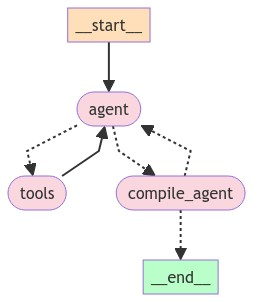

In [10]:
# parser=ToolsOutputParser()
# chain = llm_with_tools | parser
# ai_msg = chain.invoke(prompt.invoke({"input": format_input(dataset_entry)}))

# Use the Runnable
from langgraph.checkpoint.sqlite import SqliteSaver

# checkpointer = SqliteSaver.from_conn_string(f"{language_model}.db")


from langchain_core.agents import AgentActionMessageLog

from langgraph.graph import END, StateGraph, MessagesState
from typing import Annotated, Literal, TypedDict
from langgraph.prebuilt import ToolNode


def compile_agent(inputs):
    action = AgentActionMessageLog(
        tool="compile_maven_stateless",
        tool_input=inputs["input"],
        log="Finally, the diff needs to be compiled and tested.",
        message_log=[],
    )
    return {"agent_outcome": action}


def should_continue(state: MessagesState) -> Literal["tools", "compile_agent"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        print("Should_contine", "tools")
        return "tools"
    return "compile_agent"

def should_improve_non_test_diff(state: MessagesState) -> Literal["agent", END]:
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message.content)
    if "Compilation and Testing successful:" in last_message.content:
        print("Compilation and Test were successful, ending")
        return END
    return "agent"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tools=[]


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("compile_agent", compile_agent)
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_conditional_edges(
    "compile_agent",
    should_improve_non_test_diff,
)

workflow.add_edge("tools", "agent")

app = workflow.compile()

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

    # with tracer.start_as_current_span("Process Commit") as span:
    #     span.set_attribute("commit_hash", commit_hash)
    #     try:
    #         all_initial_messages = [system_prompt, HumanMessage(content=format_input(dataset_entry))]
    #         final_state = app.invoke({"messages": all_initial_messages},
    #             config={"run_name": dataset_entry.commit_hash, "recursion_limit": 20, "configurable": {"thread_id": dataset_entry.commit_hash}}
    #         )
    #         diff = final_state["messages"][-1].content

    #         maven_agent = MavenReproducerAgent(dataset_entry.repo_path)
    #         with maven_agent.start_container() as container:
    #             (compilation_has_succeeded, test_has_succeeded), error_text = (maven_agent.compile_maven([diff], run_tests=True))
    #             print("Repro Success: ", (compilation_has_succeeded, test_has_succeeded))
    #             if not compilation_has_succeeded or not test_has_succeeded:
    #                 all_initial_messages.append(AIMessage(content=diff))
    #                 all_initial_messages.append(HumanMessage(content="Compilation/Test Error: " + str(error_text)))
    #                 final_state = app.invoke({"messages": all_initial_messages},
    #                     config={"run_name": dataset_entry.commit_hash, "recursion_limit": 20, "configurable": {"thread_id": dataset_entry.commit_hash}}
    #                 )
    #             final_state["messages"][-1].content
                 
    #     except Exception as e:
    #         print(e)
    #         continue
  

# for chunk in app.stream({"messages": [HumanMessage(content=format_input(dataset_entry))]},
#     config={"configurable": {"thread_id": 421}}
# ):
#     chunk["messages"][-1].pretty_print()
#     if chunk["messages"][-1].content == "Compilation and Testing successful: ":
#         break

    

In [ ]:
app

In [ ]:
final_state["messages"][-1].pretty_print()

In [ ]:
# from langchain.agents import AgentExecutor

# agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True, return_intermediate_steps=True,
#     max_iterations=15, 
#     max_execution_time=1800)

In [ ]:
from masterthesis.dataset.load_dataset import cleanup_dataset


cleanup_dataset(candidates)

In [ ]:
# # list(agent_executor.stream({"input": format_input(dataset_entry)}))

# agent_executor.invoke({"input": format_input(dataset_entry)})